In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from mrs_denoising import denoising

# Assesment of denoising approaches on toy single peak model
In this notebook we assess the ability of of global and local spatio-temporal, linear-predictability, and global and local LORA to denoise a toy MRS signal model.

## Define local functions
### Data model
The toy data model is a single unit-amplitude on-resonance Lorentzian peak with a fwhm (in Hz) of $1/\pi\alpha$. This is modeled in the time domain as a exponentially decaying sinusoid with Gaussian noise. Following the notation of Cavassila _et al_(1):

$$x_n =  \hat{x}_n + b_n,\;\; b_n\stackrel{\mathrm{iid}}{\sim}\mathcal{N}(0,\sigma^2)$$  
$$\hat{x}_n =  \sum_{k=1}^K c_k \exp((\alpha_k+j\omega_k)nt_s)\exp(j\phi_k)$$

Here, in this toy model: $K=1, c_k = 1, \omega_k=0$ and $\phi_k=0$.


1. [Cramér-Rao Bound Expressions for Parametric Estimation of Overlapping Peaks: Influence of Prior Knowledge](https://www.sciencedirect.com/science/article/pii/S1090780799920025)

In [2]:
def fwd(x, c, alpha, omega, phi):
    return c * np.exp((alpha + 1j * omega) * x) * np.exp(1j * phi)

def generate_data(sigma, reps=1, linewidth=10, bandwidth=1000, points=512):
    dwelltime = 1 / bandwidth
    time_axis = np.arange(0.0, points*dwelltime, dwelltime)
    
    alpha = -np.pi * linewidth
    noiseless = fwd(time_axis, 1.0, alpha, 0.0, 0.0)
    
    noise = sigma/np.sqrt(2) * np.random.randn(reps,points)\
        + 1j * sigma/np.sqrt(2) * np.random.randn(reps,points)
    
    return noise + noiseless

### Fit functions
Fit the data using non-linear least square optimiser, i.e. a simplified AMARES approach.

In [3]:
def fit_func(x, c, l, o, p):
    cmplx = fwd(x[:int(x.size/2)], c, -np.pi*l, o, p)
    return np.concatenate((cmplx.real, cmplx.imag))

def fit_data(xdata, ydata):
    x0 = [1.0, 30.0, 0.0, 0.0]
    ydat = np.concatenate((ydata.real, ydata.imag))
    xdat = np.concatenate((xdata,xdata))
    xopt, xcov = curve_fit(fit_func, xdat, ydat, p0=x0)
    crlb = np.sqrt(np.diag(xcov))
                               
    return xopt, crlb

### Uncertainty Functions
As defined in Cavassila et al. Eq. [14] and Eq. [15]

In [4]:
def crlb_alpha(sigma, alpha, bandwidth=1000, conc=1):
    return 2 * np.sqrt(2) * (-alpha)**(3/2) * np.sqrt(1 / bandwidth) * (sigma / conc)

def crlb_conc(sigma, alpha, bandwidth=1000):
    return 2 * (-alpha)**(1/2) * np.sqrt(1 / bandwidth) * sigma

### Utility functions

In [5]:
def FID2Spec(FID, axis=0):
    # By convention the first point of the fid is special-cased
    ss = [slice(None) for i in range(FID.ndim)]
    ss[axis] = slice(0, 1)
    ss = tuple(ss)
    FID[ss] *= 0.5
    out = np.fft.fftshift(
        np.fft.fft(FID,
                   axis=axis,
                   norm='ortho'),axes=axis)
    FID[ss] *= 2
    return out

## Make some data
### An example plot

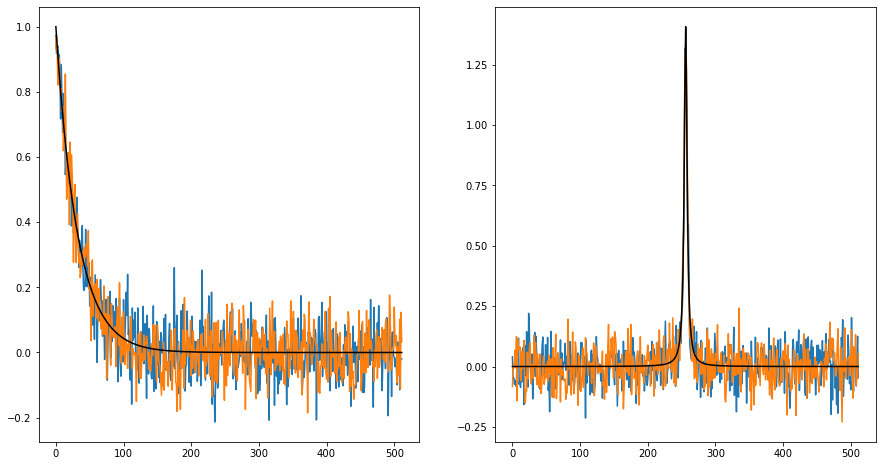

In [6]:
data = generate_data(0.1, reps=2)
data_noiseless = generate_data(0.0)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(data.T.real)
ax1.plot(data_noiseless.T.real,'k')

ax2.plot(FID2Spec(data.T).real)
ax2.plot(FID2Spec(data_noiseless.T).real,'k')
plt.show()

### Example fit

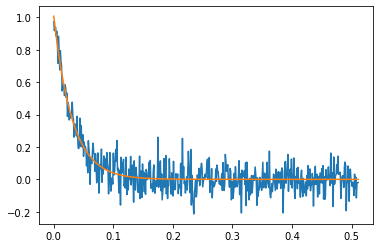

amplitude = 1.01±0.03
linewidth = 10.29±0.37
omega = 0.23±1.16
phi = 0.02±0.03


In [7]:
dwelltime = 1 / 1000
points = 512
t_axis = np.arange(0.0, points*dwelltime, dwelltime)

xout, x_sd = fit_data(t_axis, data[0,:])

c, l, o, p = xout

plt.plot(t_axis,data[0,:].real)
plt.plot(t_axis,fwd(t_axis,c, -np.pi*l, o, p).real)
plt.show()
print(f'amplitude = {c:0.2f}±{x_sd[0]:0.2f}')
print(f'linewidth = {l:0.2f}±{x_sd[1]:0.2f}')
print(f'omega = {o:0.2f}±{x_sd[2]:0.2f}')
print(f'phi = {p:0.2f}±{x_sd[3]:0.2f}')

### Now more repetitions for the evaluation of the denoising
Construct noisy data with a number of 'voxels' and Monte Carlo repeats

In [8]:
data_shape = (8,8,1)
mc_rep = 160
noisy_data = generate_data(0.1, reps=np.prod(data_shape) * mc_rep)
noisy_data = noisy_data.reshape((mc_rep,) + data_shape + (512,))
noisy_data.shape

(160, 8, 8, 1, 512)

## Qualitatively evaluate variance after each type of denoising
### Run the denoising on the noisy data generated above
The next cell takes a little while to run

In [9]:
# Global ST denoising, rank = 1
st_denoised = [denoising.st_denoising(nd,rank=1)[0] for nd in noisy_data]
st_denoised = np.asarray(st_denoised)

# LP denoising, rank = 1
lp_denoised = [denoising.lp(nd,1) for nd in noisy_data]
lp_denoised = np.asarray(lp_denoised)

# LORA denoising, r1 = 1, r2 = 1
lora_denoised = [denoising.lora(nd, 1, 1) for nd in noisy_data]
lora_denoised = np.asarray(lora_denoised)

### Plot the Monte Carlo standard deviation as a function of frequency 

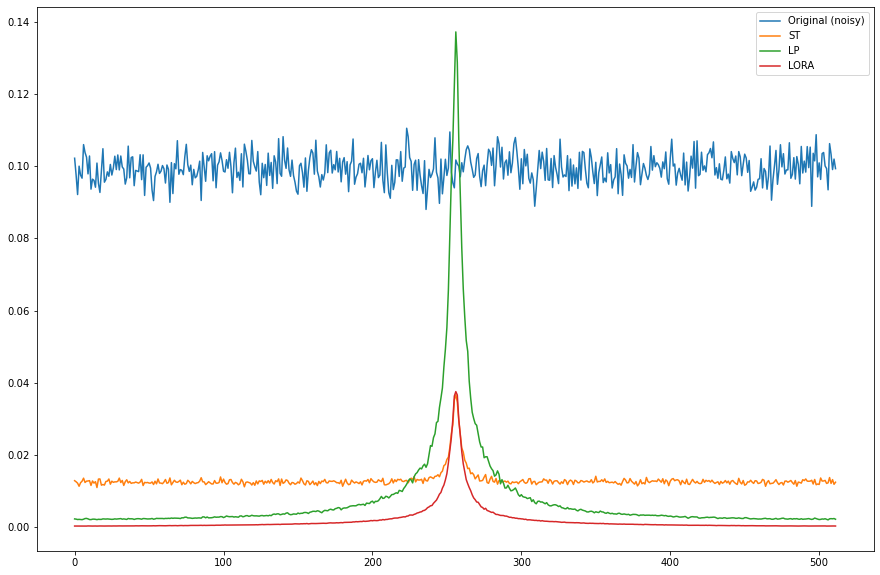

In [10]:
fig = plt.figure(figsize=(15,10))
plt.plot(np.std(FID2Spec(noisy_data,axis=4)[:,6,6,0,:],axis=0), label='Original (noisy)')
plt.plot(np.std(FID2Spec(st_denoised,axis=4)[:,6,6,0,:],axis=0), label='ST')
plt.plot(np.std(FID2Spec(lp_denoised,axis=4)[:,6,6,0,:],axis=0), label='LP')
plt.plot(np.std(FID2Spec(lora_denoised,axis=4)[:,6,6,0,:],axis=0), label='LORA')
plt.legend()
plt.show()

### Generate Fig 1
Explanatory figure for different denoising approaches

In [11]:
def plot_with_shaded_std(ax,xpos, all_data, xrange, label1=None, label2=None):
    all_data = all_data.copy().reshape(-1,all_data.shape[-1])
    to_plot = FID2Spec(all_data[0])[xrange]
    xindicies = xpos + np.arange(0,len(to_plot))
    ax.plot(xindicies,to_plot.real,'k', label=label1)
    
    mean = np.mean(FID2Spec(all_data,axis=1)[:,xrange], axis=0)
    std = 1.96 * np.std(FID2Spec(all_data,axis=1)[:,xrange], axis=0)
    ax.fill_between(xindicies, mean.real - std, mean.real + std, color='b', alpha=0.2, label=label2)

def plot_std(ax,xpos,all_data,xrange,xrange_noise, label1=None, label2=None):
    all_data = all_data.copy().reshape(-1,all_data.shape[-1])
    to_plot = FID2Spec(all_data[0])[xrange]
    xindicies = xpos + np.arange(0,len(to_plot))
    std = np.std(FID2Spec(all_data,axis=1)[:,xrange], axis=0)
    ax.plot(xindicies,std,'k',label=label1)
    std2 = np.std(FID2Spec(all_data,axis=1)[:,xrange_noise])
    ax.hlines(std2,xindicies[0],xindicies[-1],'r',linestyle='--',label=label2)

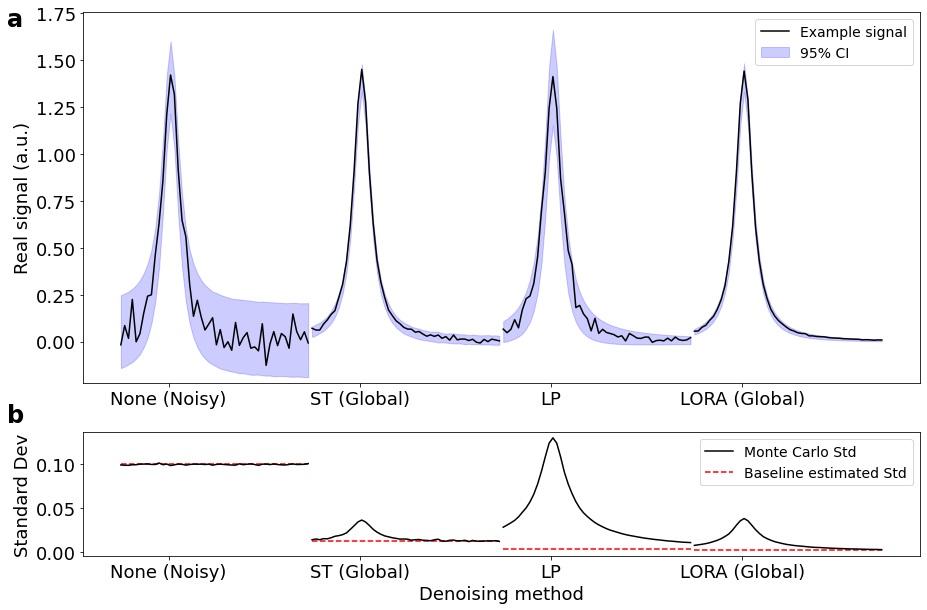

In [12]:
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=14)    # legend fontsize
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3, 1]})
xrange = 50
xslice = slice(int(256-xrange/4),int(256+3*xrange/4))
plot_with_shaded_std(ax1,0,noisy_data,xslice)
plot_with_shaded_std(ax1,xrange,st_denoised,xslice)
plot_with_shaded_std(ax1,xrange*2,lp_denoised,xslice)
plot_with_shaded_std(ax1,xrange*3,lora_denoised,xslice, label1='Example signal', label2='95% CI')
ax1.set_xticks([xrange/4, xrange+xrange/4, 2*xrange+xrange/4, 3*xrange+xrange/4])
ax1.set_xticklabels(['None (Noisy)', 'ST (Global)', 'LP', 'LORA (Global)'])
ax1.set_ylim([-0.22,None])
ax1.set_ylabel('Real signal (a.u.)')
ax1.legend(loc=1)
fig.text(0.055, 0.86,'a',fontweight='bold',fontsize=24)

noise_slice = slice(0,50)
plot_std(ax2,0,noisy_data,xslice,noise_slice)
plot_std(ax2,xrange,st_denoised,xslice,noise_slice)
plot_std(ax2,xrange*2,lp_denoised,xslice,noise_slice)
plot_std(ax2,xrange*3,lora_denoised,xslice,noise_slice, label1='Monte Carlo Std', label2='Baseline estimated Std')
ax2.set_xticks([xrange/4, xrange+xrange/4, 2*xrange+xrange/4, 3*xrange+xrange/4])
ax2.set_xticklabels(['None (Noisy)', 'ST (Global)', 'LP', 'LORA (Global)'])
ax2.set_ylabel('Standard Dev')
ax2.set_xlabel('Denoising method')
ax2.legend()
fig.text(0.055, 0.31,'b',fontweight='bold',fontsize=24)

plt.savefig('figures/figure_4_single_peak_var.png', bbox_inches='tight', dpi=300)

### Evaluate patch based ST denoising and variance estimation

In [13]:
patch_st_denoised = [denoising.st_denoising(nd,rank=1,patch=[2,2,1])[0] for nd in noisy_data]
patch_st_denoised = np.asarray(patch_st_denoised)

# Also capture the estimated variance from each type of ST denoising
patch_st_var = denoising.st_denoising(noisy_data[0],rank=1,patch=[2,2,1])[1]
st_var = denoising.st_denoising(noisy_data[0],rank=1)[1]
patch_st_var *= np.var(noisy_data[0, 4, 4, 0, 300:512])
st_var *= np.var(noisy_data[0, 4, 4, 0, 300:512])

### Generate figure 2

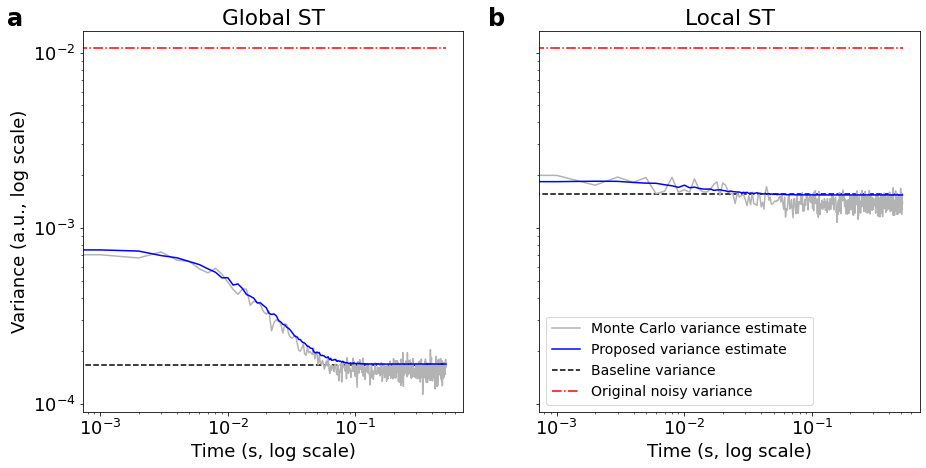

In [14]:
dwelltime = 1 / 1000
points = 512
t_axis = np.arange(0.0, points*dwelltime, dwelltime)

def plot_var2(ax,all_data,est_var,xrange_noise, noisy_var, labels=[None, None, None, None]):
    std = np.var(all_data[:,4,4,0,:], axis=0)
    std2 = np.var(all_data[0,4,4,0, xrange_noise])
    ax.plot(t_axis, std,color=[0.7, 0.7, 0.7], label=labels[0])
    ax.plot(t_axis, est_var[4,4,0,:],'b',label=labels[1])
    ax.hlines(std2, t_axis[0], t_axis[-1],'k',linestyle='--',label=labels[2])
    ax.hlines(noisy_var, t_axis[0], t_axis[-1],'r',linestyle='-.',label=labels[3])
    ax.set_xscale('log')
    ax.set_yscale('log')

noise_slice = slice(300,512)
noisy_var = np.var(noisy_data[0, 4, 4, 0, 300:512])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7),sharey=True)
plot_var2(ax1,st_denoised,st_var,noise_slice, noisy_var)
plot_var2(ax2,
          patch_st_denoised,
          patch_st_var,
          noise_slice,
          noisy_var,
          labels = ['Monte Carlo variance estimate',
                    'Proposed variance estimate',
                    'Baseline variance',
                    'Original noisy variance'])

ax1.set_ylabel('Variance (a.u., log scale)')
ax1.set_xlabel('Time (s, log scale)')
ax2.set_xlabel('Time (s, log scale)')
ax1.set_title('Global ST')
ax2.set_title('Local ST')
ax2.legend(loc=3)
fig.text(0.055, 0.89,'a',fontweight='bold',fontsize=24)
fig.text(0.5, 0.89,'b',fontweight='bold',fontsize=24)
plt.savefig('figures/figure_5_single_peak_var_est.png', bbox_inches='tight', dpi=300)

### Covariance estimation

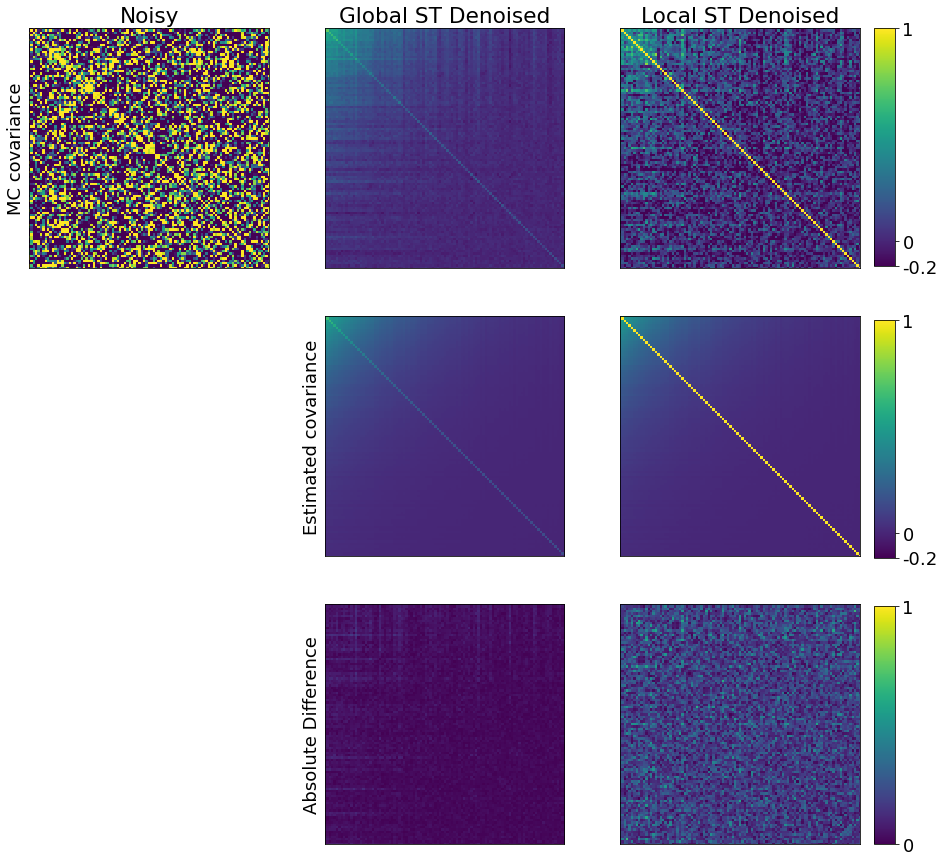

In [19]:
patch_st_covar = denoising.st_denoising(noisy_data[0],rank=1,patch=[2,2,1])[2]
st_covar = denoising.st_denoising(noisy_data[0],rank=1)[2]

patch_st_covar *= noisy_var
patch_st_covar -= np.diag(np.diag(patch_st_covar))
patch_st_covar += np.diag(patch_st_var[4,4,0,:]) 

st_covar *= noisy_var
st_covar -= np.diag(np.diag(st_covar))
st_covar += np.diag(st_var[4,4,0,:]) 

mc_covar_noisy = np.cov(noisy_data[:,4,4,0,:].T)
mc_covar_st_denoised = np.cov(st_denoised[:,4,4,0,:].T)
mc_covar_patch_st_denoised = np.cov(patch_st_denoised[:,4,4,0,:].T)

def plot_mat(ax, data, vmin, vmax):
    im = ax.matshow(data.real, vmin=vmin , vmax=vmax)
    ax.set_xlim([0, 100])
    ax.set_ylim([100, 0])
    ax.set_xticks([])
    ax.set_yticks([])
    return im

vmin = np.min(mc_covar_st_denoised.real)
vmax = np.max(mc_covar_patch_st_denoised.real)/2
fig, axes = plt.subplots(3,3,figsize=(15,15))
plot_mat(axes[0,0], mc_covar_noisy, vmin, vmax)
plot_mat(axes[0,1], mc_covar_st_denoised, vmin, vmax)
im = plot_mat(axes[0,2], mc_covar_patch_st_denoised, vmin, vmax)
cax = fig.add_axes([0.91, 0.66, 0.02, 0.22])
cb = plt.colorbar(im, cax=cax, ticks=[vmin, 0, vmax])
cb.ax.set_yticklabels(['-0.2', '0', '1'])

axes[1,0].axis('off')
plot_mat(axes[1,1], st_covar, vmin, vmax)
im = plot_mat(axes[1,2], patch_st_covar, vmin, vmax)
cax = fig.add_axes([0.91, 0.39, 0.02, 0.22])
cb = plt.colorbar(im, cax=cax, ticks=[vmin, 0, vmax])
cb.ax.set_yticklabels(['-0.2', '0', '1'])

axes[2,0].axis('off')
plot_mat(axes[2,1], np.abs(st_covar-mc_covar_st_denoised), 0, vmax)
im = plot_mat(axes[2,2], np.abs(patch_st_covar-mc_covar_patch_st_denoised), 0, vmax)
cax = fig.add_axes([0.91, 0.125, 0.02, 0.22])
cb = plt.colorbar(im, cax=cax, ticks=[0, vmax])
cb.ax.set_yticklabels(['0', '1'])

axes[0,0].set_title('Noisy')
axes[0,1].set_title('Global ST Denoised')
axes[0,2].set_title('Local ST Denoised')

axes[0,0].set_ylabel('MC covariance')
axes[1,1].set_ylabel('Estimated covariance')
axes[2,1].set_ylabel('Absolute Difference')
plt.savefig('figures/supp_fig_3_sp_covar.png', bbox_inches='tight', dpi=300)

## Fit the denoised data using our simple model to assess fitted parameter uncertainty

In [20]:
noisy_param, noisy_sd = [], []
gst_param, gst_sd = [], []
lst_param, lst_sd = [], []
lp_param, lp_sd = [], []
lo_param, lo_sd = [], []

for nd, g_st, l_st, lp, lo in zip(noisy_data,
                                  st_denoised,
                                  patch_st_denoised,
                                  lp_denoised,
                                  lora_denoised):
    xout, x_sd = fit_data(t_axis, nd[4,4,0,:])
    noisy_param.append(xout)
    noisy_sd.append(x_sd)
    
    xout, x_sd = fit_data(t_axis, g_st[4,4,0,:])
    gst_param.append(xout)
    gst_sd.append(x_sd)
    
    xout, x_sd = fit_data(t_axis, l_st[4,4,0,:])
    lst_param.append(xout)
    lst_sd.append(x_sd)
    
    xout, x_sd = fit_data(t_axis, lp[4,4,0,:])
    lp_param.append(xout)
    lp_sd.append(x_sd)
    
    xout, x_sd = fit_data(t_axis, lo[4,4,0,:])
    lo_param.append(xout)
    lo_sd.append(x_sd)
    
noisy_param = np.asarray(noisy_param)
noisy_sd = np.asarray(noisy_sd)
gst_param = np.asarray(gst_param)
gst_sd = np.asarray(gst_sd)
lst_param = np.asarray(lst_param)
lst_sd = np.asarray(lst_sd)
lp_param = np.asarray(lp_param)
lp_sd = np.asarray(lp_sd)
lo_param = np.asarray(lo_param)
lo_sd = np.asarray(lo_sd)

We observe a difference between the true (MC measured) uncertainty and that estimated from the noise apparent in the fitting residual.  
We also observe that LP denoising increases the uncertainty compared to the noisy case. And that LORA, whilst improving the apparent denoising over ST does not show an improvement in MC measured amplitude uncertainty.

In [21]:
print(f'Noisy: mc={noisy_param.std(axis=0)[0]:0.3f}, est={noisy_sd.mean(axis=0)[0]:0.3f} ')
print(f'Global ST: mc={gst_param.std(axis=0)[0]:0.3f}, est={gst_sd.mean(axis=0)[0]:0.3f} ')
print(f'Local ST: mc={lst_param.std(axis=0)[0]:0.3f}, est={lst_sd.mean(axis=0)[0]:0.3f} ')
print(f'LP: mc={lp_param.std(axis=0)[0]:0.3f}, est={lp_sd.mean(axis=0)[0]:0.3f} ')
print(f'LORA: mc={lo_param.std(axis=0)[0]:0.3f}, est={lo_sd.mean(axis=0)[0]:0.3f} ')

Noisy: mc=0.026, est=0.024 
Global ST: mc=0.018, est=0.003 
Local ST: mc=0.019, est=0.009 
LP: mc=0.032, est=0.004 
LORA: mc=0.018, est=0.000 


## Estimate the true uncertainty using a boot-strapping approach
Only do this for the (global and local) ST denoising for which we have a good approximation of the covariance.  

We also need to form the covariance matrix for the split real/imaginary channels

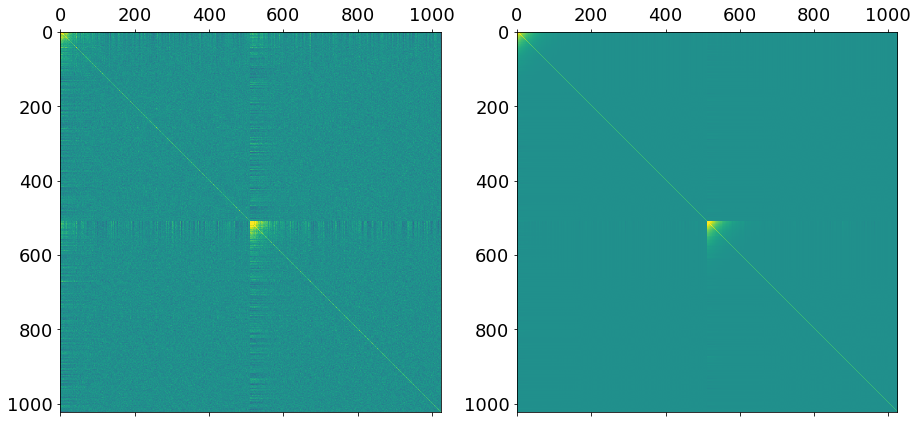

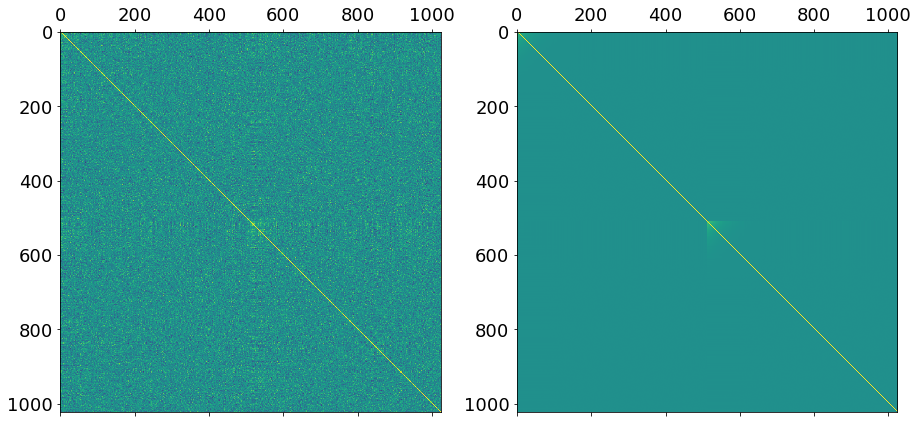

In [22]:
# Noisy
mc_covar_noisy_split = np.cov(np.concatenate((noisy_data[:,4,4,0,:].real,noisy_data[:,4,4,0,:].imag), axis=1).T)

# ST Global
target_covar = np.cov(np.concatenate((st_denoised[:,4,4,0,:].real,st_denoised[:,4,4,0,:].imag), axis=1).T)
_,var,covar = denoising.st_denoising(noisy_data[0],rank=1)
heuristic_split_cov_stg = np.block([[covar.real,covar.imag],[covar.imag.T,covar.real]])
heuristic_split_cov_stg -= np.diag(np.diag(heuristic_split_cov_stg))
heuristic_split_cov_stg += np.diag(np.concatenate((var[4,4,0,:], var[4,4,0,:])))
heuristic_split_cov_stg *= noisy_var/2
# Plot
vmax = np.max(target_covar)/2
vmin = -1 * vmax
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.matshow(target_covar, vmin=vmin, vmax=vmax)
ax2.matshow(heuristic_split_cov_stg, vmin=vmin, vmax=vmax)
plt.show()

# ST Local
target_covar = np.cov(np.concatenate((patch_st_denoised[:,4,4,0,:].real,patch_st_denoised[:,4,4,0,:].imag), axis=1).T)
_,var,covar = denoising.st_denoising(noisy_data[0],rank=1,patch=[2,2,1])
heuristic_split_cov_stl = np.block([[covar.real,covar.imag],[covar.imag.T,covar.real]])
heuristic_split_cov_stl -= np.diag(np.diag(heuristic_split_cov_stl))
heuristic_split_cov_stl += np.diag(np.concatenate((var[4,4,0,:], var[4,4,0,:])))
heuristic_split_cov_stl *= noisy_var/2
# Plot
vmax = np.max(target_covar)/2
vmin = -1 * vmax
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.matshow(target_covar, vmin=vmin, vmax=vmax)
ax2.matshow(heuristic_split_cov_stl, vmin=vmin, vmax=vmax)
plt.show()




In [19]:

def boostrap_gen(data, covar):
    shape = data.size
    peturbed = rng.multivariate_normal(np.concatenate((data.real, data.imag)),
                                       covar,
                                       check_valid='ignore')
    return peturbed[:shape] + 1j * peturbed[shape:]

def boot_strap_fit(data, covar, reps=50):
    xout = []
    for idx in range(reps):
        cov_petub = boostrap_gen(data, covar)
        xout.append(fit_data(t_axis, cov_petub)[0])
    return np.mean(xout, axis=0), np.std(xout, axis=0)

x_bs_noisy, x_std_bs_noisy = boot_strap_fit(generate_data(0.0)[0,:], mc_covar_noisy_split, reps=100)
x_bs_st, x_std_bs_st = boot_strap_fit(st_denoised[0,4,4,0,:], heuristic_split_cov_stg, reps=100)
x_bs_lst, x_std_bs_lst = boot_strap_fit(patch_st_denoised[0,4,4,0,:], heuristic_split_cov_stl, reps=100)

print(f'Noisy: mc={noisy_param.std(axis=0)[0]:0.3f}, est={noisy_sd.mean(axis=0)[0]:0.3f}, bs={x_std_bs_noisy[0]:0.3f}')
print(f'Global ST: mc={gst_param.std(axis=0)[0]:0.3f}, est={gst_sd.mean(axis=0)[0]:0.3f}, bs={x_std_bs_st[0]:0.3f}')
print(f'Local ST: mc={lst_param.std(axis=0)[0]:0.3f}, est={lst_sd.mean(axis=0)[0]:0.3f}, bs={x_std_bs_lst[0]:0.3f} ')

Noisy: mc=0.022, est=0.024, bs=0.023
Global ST: mc=0.017, est=0.003, bs=0.018
Local ST: mc=0.018, est=0.009, bs=0.019 


## Repeat above analysis at different noise levels to generate figure 

In [23]:
def gen_heuristic_cov(noisy_var, var, cmplxcov):
    large_cov = np.block([[cmplxcov.real, cmplxcov.imag], [cmplxcov.imag.T, cmplxcov.real]])
    large_cov -= np.diag(np.diag(large_cov))
    large_cov += np.diag(np.concatenate((var, var)))
    large_cov *= noisy_var / 2
    return large_cov

In [24]:
def single_peak_analysis(noiselevel, voxels=(8,8,1), repetitions=10):
    selvox = [int(v/2) for v in voxels]  
    
    noisy_data = generate_data(noiselevel, reps=np.prod(voxels) * repetitions)
    noisy_data = noisy_data.reshape((repetitions,) + voxels + (512,))
    
    st_denoised = []
    st_covar = []
    patch_st_denoised = []
    patch_st_covar = []
    for nd in noisy_data:
        in_noise_var = np.var(nd[selvox[0],selvox[1],selvox[2],300:])
        tmp = denoising.st_denoising(nd, rank=1)
        st_denoised.append(tmp[0])
        st_covar.append(gen_heuristic_cov(in_noise_var,
                                          tmp[1][selvox[0],selvox[1],selvox[2],:],
                                          tmp[2]))
        
        tmp = denoising.st_denoising(nd, rank=1, patch=[2,2,1])
        patch_st_denoised.append(tmp[0])
        patch_st_covar.append(gen_heuristic_cov(in_noise_var,
                                                tmp[1][selvox[0],selvox[1],selvox[2],:],
                                                tmp[2]))

    st_denoised = np.asarray(st_denoised)
    patch_st_denoised = np.asarray(patch_st_denoised)    
    
    lp_denoised = [denoising.lp(nd,1) for nd in noisy_data]
    lp_denoised = np.asarray(lp_denoised)

    lora_denoised = [denoising.lora(nd, 1, 1) for nd in noisy_data]
    lora_denoised = np.asarray(lora_denoised)
    
    noisy_param, noisy_sd = [], []
    gst_param, gst_sd, gst_bs = [], [], []
    lst_param, lst_sd, lst_bs = [], [], []
    lp_param, lp_sd = [], []
    lo_param, lo_sd = [], []                    
    for nd, g_st, l_st, g_cov, l_cov, lp, lo in zip(noisy_data,
                                                    st_denoised,
                                                    patch_st_denoised,
                                                    st_covar,
                                                    patch_st_covar,
                                                    lp_denoised,
                                                    lora_denoised):
        xout, x_sd = fit_data(t_axis, nd[selvox[0],selvox[1],selvox[2],:])
        noisy_param.append(xout)
        noisy_sd.append(x_sd)

        xout, x_sd = fit_data(t_axis, g_st[selvox[0],selvox[1],selvox[2],:])
        gst_param.append(xout)
        gst_sd.append(x_sd)

        xout, x_sd = fit_data(t_axis, l_st[selvox[0],selvox[1],selvox[2],:])
        lst_param.append(xout)
        lst_sd.append(x_sd)

        xout, x_sd = fit_data(t_axis, lp[selvox[0],selvox[1],selvox[2],:])
        lp_param.append(xout)
        lp_sd.append(x_sd)

        xout, x_sd = fit_data(t_axis, lo[selvox[0],selvox[1],selvox[2],:])
        lo_param.append(xout)
        lo_sd.append(x_sd)
        
        # BS fitting for ST cases
        
        _, x_std_bs_st = boot_strap_fit(g_st[selvox[0],selvox[1],selvox[2],:],
                                        g_cov,
                                        reps=100)
        gst_bs.append(x_std_bs_st)
        _, x_std_bs_lst = boot_strap_fit(l_st[selvox[0],selvox[1],selvox[2],:],
                                         l_cov,
                                         reps=100)
        lst_bs.append(x_std_bs_lst)
        
    noisy_mc_var = np.std(noisy_param, axis=0)
    noisy_fit_var = np.mean(noisy_sd, axis=0)
    gst_mc_var = np.std(gst_param, axis=0)
    gst_fit_var = np.mean(gst_sd, axis=0)
    gst_bs_var = np.mean(gst_bs, axis=0)
    lst_mc_var = np.std(lst_param, axis=0)
    lst_fit_var = np.mean(lst_sd, axis=0)
    lst_bs_var = np.mean(lst_bs, axis=0)
    lp_mc_var = np.std(lp_param, axis=0)
    lp_fit_var = np.mean(lp_sd, axis=0)
    lo_mc_var = np.std(lo_param, axis=0)
    lo_fit_var = np.mean(lo_sd, axis=0)
    
    index = np.array(['noise',
                      'noisy_mc', 'noisy_fit',
                      'gloabl_st_mc', 'gloabl_st_fit', 'gloabl_st_bs',
                      'local_st_mc', 'local_st_fit', 'local_st_bs',
                      'lp_mc', 'lp_fit',
                      'lora_mc', 'lora_fit'])
    data = np.array([noiselevel,
                     noisy_mc_var[0], noisy_fit_var[0],
                     gst_mc_var[0], gst_fit_var[0], gst_bs_var[0],
                     lst_mc_var[0], lst_fit_var[0], lst_bs_var[0],
                     lp_mc_var[0], lp_fit_var[0],
                     lo_mc_var[0], lo_fit_var[0]])
    
    return pd.Series(data=data, index=index)


In [25]:
noise_levels = [0.5, 0.1 , 0.05, 0.01, 0.005, 0.001]

# Uncomment to run analysis first time around
# all_noise_df = []
# for nl in noise_levels:
#     all_noise_df.append(single_peak_analysis(nl, voxels=(8,8,1), repetitions=50))
#     print(f'{nl} done.')
# all_noise_df = pd.concat(all_noise_df,axis=1).T.set_index('noise')
# pd.to_pickle(all_noise_df,'save_var/single_peak_df.p')

# Comment if not run before
all_noise_df = pd.read_pickle('save_var/single_peak_df.p')

In [26]:
# Estimate uncertainty of averaged data (sqrt(N))
avg_est = all_noise_df['noisy_mc'] / np.sqrt(np.prod((8,8,1)))

In [59]:
means_mc = [(all_noise_df['noisy_mc']/all_noise_df['noisy_mc']).mean(),
            (all_noise_df['gloabl_st_mc']/all_noise_df['noisy_mc']).mean(),
            (all_noise_df['local_st_mc']/all_noise_df['noisy_mc']).mean(),
            (all_noise_df['lp_mc']/all_noise_df['noisy_mc']).mean(),
            (all_noise_df['lora_mc']/all_noise_df['noisy_mc']).mean()]
means_fit = [(all_noise_df['noisy_fit']/all_noise_df['noisy_mc']).mean(),
             (all_noise_df['gloabl_st_fit']/all_noise_df['noisy_mc']).mean(),
             (all_noise_df['local_st_fit']/all_noise_df['noisy_mc']).mean(),
             (all_noise_df['lp_fit']/all_noise_df['noisy_mc']).mean(),
             (all_noise_df['lora_fit']/all_noise_df['noisy_mc']).mean()]

sd_mc = [0,
            (all_noise_df['gloabl_st_mc']/all_noise_df['noisy_mc']).std(),
            (all_noise_df['local_st_mc']/all_noise_df['noisy_mc']).std(),
            (all_noise_df['lp_mc']/all_noise_df['noisy_mc']).std(),
            (all_noise_df['lora_mc']/all_noise_df['noisy_mc']).std()]
sd_fit = [(all_noise_df['noisy_fit']/all_noise_df['noisy_mc']).std(),
             (all_noise_df['gloabl_st_fit']/all_noise_df['noisy_mc']).std(),
             (all_noise_df['local_st_fit']/all_noise_df['noisy_mc']).std(),
             (all_noise_df['lp_fit']/all_noise_df['noisy_mc']).std(),
             (all_noise_df['lora_fit']/all_noise_df['noisy_mc']).std()]

means_bs = [0,
            (all_noise_df['gloabl_st_bs']/all_noise_df['noisy_mc']).mean(),
            (all_noise_df['local_st_bs']/all_noise_df['noisy_mc']).mean()]
std_bs = [0,
          (all_noise_df['gloabl_st_bs']/all_noise_df['noisy_mc']).std(),
            (all_noise_df['local_st_bs']/all_noise_df['noisy_mc']).std()]



labels = ['Noisy', 'Global ST', 'Local ST', 'LP', 'LORA']


### Figure 4 supporting

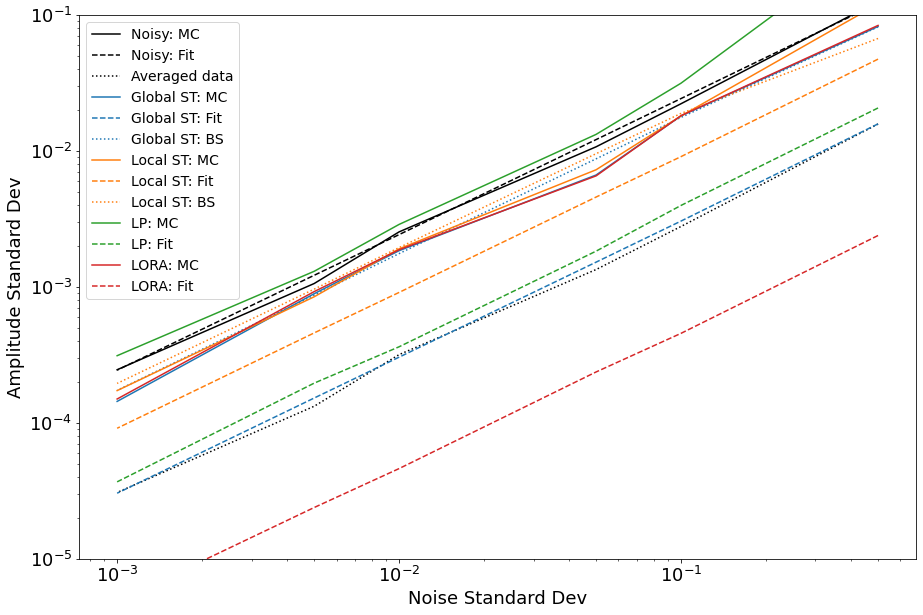

In [57]:
x_vals = all_noise_df.index.to_numpy()
fig = plt.figure(figsize=(15,10))
colors = []
line, = plt.loglog(x_vals,all_noise_df['noisy_mc'],'k',label='Noisy: MC')
plt.loglog(x_vals,all_noise_df['noisy_fit'],'k--',label='Noisy: Fit')
plt.loglog(x_vals,avg_est,'k:',label='Averaged data')
colors.append(line.get_color())

line, = plt.loglog(x_vals,all_noise_df['gloabl_st_mc'],label='Global ST: MC')
plt.loglog(x_vals,all_noise_df['gloabl_st_fit'],color=line.get_color(),linestyle='--',label='Global ST: Fit')
plt.loglog(x_vals,all_noise_df['gloabl_st_bs'],color=line.get_color(),linestyle=':',label='Global ST: BS')
colors.append(line.get_color())

line, = plt.loglog(x_vals,all_noise_df['local_st_mc'],label='Local ST: MC')
plt.loglog(x_vals,all_noise_df['local_st_fit'],color=line.get_color(),linestyle='--',label='Local ST: Fit')
plt.loglog(x_vals,all_noise_df['local_st_bs'],color=line.get_color(),linestyle=':',label='Local ST: BS')
colors.append(line.get_color())

line, = plt.loglog(x_vals,all_noise_df['lp_mc'],label='LP: MC')
plt.loglog(x_vals,all_noise_df['lp_fit'],color=line.get_color(),linestyle='--',label='LP: Fit')
colors.append(line.get_color())

line, = plt.loglog(x_vals,all_noise_df['lora_mc'],label='LORA: MC')
plt.loglog(x_vals,all_noise_df['lora_fit'],color=line.get_color(),linestyle='--',label='LORA: Fit')
colors.append(line.get_color())

for lin in ax1.lines:  
    lin.set_linewidth(2)
plt.ylim(10E-6, 10E-2)
plt.xlabel('Noise Standard Dev')
plt.ylabel('Amplitude Standard Dev')
plt.legend()

plt.savefig('figures/supp_fig_4_sp_all.png', bbox_inches='tight', dpi=300)

### Figure 4

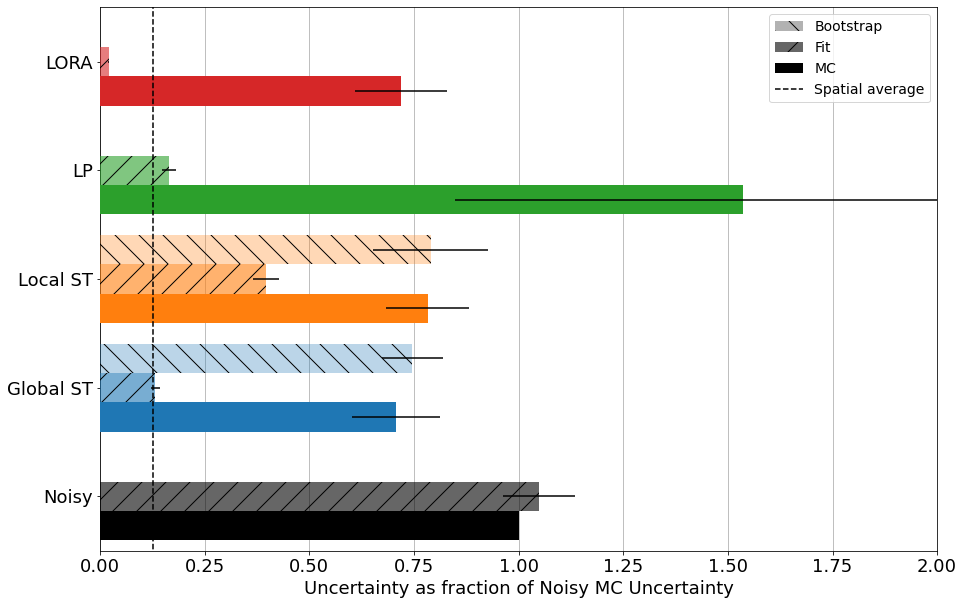

In [60]:
x_vals = all_noise_df.index.to_numpy()
fig = plt.figure(figsize=(15,10))

x = np.arange(len(labels))  # the label locations
xbs = np.array([0,1,2])
width = 0.27  # the width of the bars

rects1 = plt.barh(x - width, means_mc, width, xerr=sd_mc, label='MC', color=colors, zorder=3)
rects2 = plt.barh(x , means_fit, width, xerr=sd_fit, label='Fit', color=colors,hatch='/',alpha=0.6, zorder=3)
rects3 = plt.barh(xbs + width, means_bs, width, xerr=std_bs, label='Bootstrap', color=colors[0:3],hatch='\\',alpha=0.3, zorder=3)
plt.vlines(means_mc[0]/np.sqrt(np.prod((8,8,1))),-1,4.5,colors='k',linestyles='--', label='Spatial average', zorder=4)
plt.xlabel('Uncertainty as fraction of Noisy MC Uncertainty')
plt.xlim(0.0, 2.0)
plt.ylim(-0.5, 4.5)
plt.yticks(x, labels)
handles, hl = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], hl[::-1])
plt.grid(axis='x', zorder=0)

plt.savefig('figures/figure_6_sp_summary.png', bbox_inches='tight', dpi=300)

### Simplified figure for ISMRM abstract

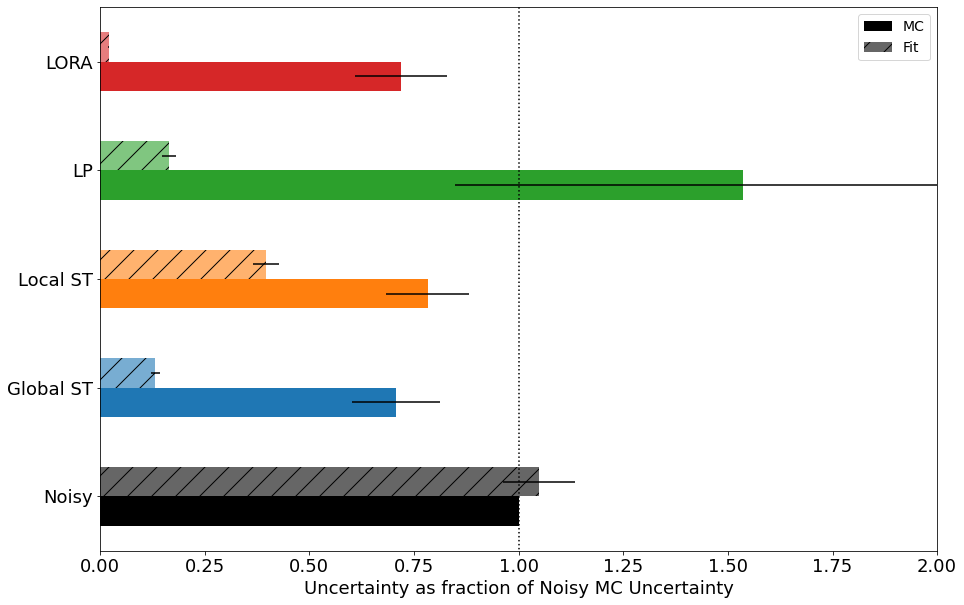

In [55]:
x_vals = all_noise_df.index.to_numpy()
fig = plt.figure(figsize=(15,10))

x = np.arange(len(labels))  # the label locations
xbs = np.array([0,1,2])
width = 0.27  # the width of the bars

rects1 = plt.barh(x - width/2, means_mc, width, xerr=sd_mc, label='MC', color=colors)
rects2 = plt.barh(x + width/2 , means_fit, width, xerr=sd_fit, label='Fit', color=colors,hatch='/',alpha=0.6)
plt.vlines(1,-1,4.5,colors='k',linestyles=':')
plt.vlines(1,-1,4.5,colors='k',linestyles=':')
plt.xlabel('Uncertainty as fraction of Noisy MC Uncertainty')
plt.xlim(0.0, 2.0)
plt.ylim(-0.5, 4.5)
plt.yticks(x,labels)
plt.legend()


plt.savefig('figures/figure_6_horizontal.png', bbox_inches='tight', dpi=300)